In [1]:
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
class CommNet(nn.Module):

    def __init__(self, args):
        '''
        args = (
        agent_num: int,
        hid_size: int,
        obs_size: [int],
        continuous: bool,
        action_dim: [int],
        comm_iters: int,
        init_std: float,
        'lrate': float,
        'batch_size': int,
        'max_steps': int,
        'gamma': float,
        'mean_ratio': float,
        'normalize_rewards': bool,
        'advantages_per_action': bool,
        'value_coeff': float,
        'entr': float
        )
        args is a namedtuple, e.g. args = collections.namedtuple()
        '''
        super(CommNet, self).__init__()
        self.args = args
        # create a model
        self.construct_model()
        # initialize parameters with normal distribution with mean of 0
        map(self.init_weights, self.parameters())
    
    def mask_obs(self, x):
        x_lens = [len(x_) for x_ in x]
        x_len_max = np.max(x_lens)
        for i in range(len(x_lens)):
            if x_lens[i] < x_len_max:
                x[i] = np.concatenate((x[i], np.zeros(x_len_max-x_len)), axis=0)
        return x
    
    def construct_model(self):
        '''
        define the model of vanilla CommNet
        '''
        # encoder transforms observation to latent variables
        self.encoder = nn.Linear(self.args.obs_size, self.args.hid_size)
        # communication mask where the diagnal should be 0
        self.comm_mask = torch.ones(self.args.agent_num, self.args.agent_num) - torch.eye(self.args.agent_num, self.args.agent_num)
        # decoder transforms hidden states to action vector
        if self.args.continuous:
            self.action_mean = nn.Linear(self.args.hid_size, self.args.action_dim)
            self.action_log_std = nn.Parameter(torch.zeros(1, self.args.action_dim))
        else:
            self.action_head = nn.Linear(self.args.hid_size, self.args.action_dim)
        # define communication inference
        self.f_module = nn.Linear(self.args.hid_size, self.args.hid_size)
        self.f_modules = nn.ModuleList([self.f_module for _ in range(self.args.comm_iters)])
        # define communication encoder
        self.C_module = nn.Linear(self.args.hid_size, self.args.hid_size)
        self.C_modules = nn.ModuleList([self.C_module for _ in range(self.args.comm_iters)])
        # define value function
        self.value_head = nn.Linear(self.args.hid_size, 1)
        self.tanh = nn.Tanh()

    def state_encoder(self, x):
        '''
        define a single forward pass of communication inference
        '''
        return self.tanh(self.encoder(self.mask_obs(x)))

    def get_agent_mask(self, batch_size, info):
        '''
        define the getter of agent mask to confirm the living agent
        '''
        n = self.args.agent_num
        with torch.no_grad():
            if 'alive_mask' in info:
                agent_mask = torch.from_numpy(info['alive_mask'])
                num_agents_alive = agent_mask.sum()
            else:
                agent_mask = torch.ones(n)
                num_agents_alive = n
        # shape = (1, 1, n)
        agent_mask = agent_mask.view(1, 1, n)
        # shape = (batch_size, n ,n, 1)
        agent_mask = agent_mask.expand(batch_size, n, n).unsqueeze(-1)
        return num_agents_alive, agent_mask

    def action(self, obs, info={}):
        '''
        define the action process of vanilla CommNet
        '''
        length = 0
        for o in obs:
            if o.shape[0] > length:
                length = o.shape[0]
        i = 0
        for o in obs:
            if o.shape[0] < length:
                obs[i] = np.concatenate((o, np.zeros(length-o.shape[0])))
            i += 1
        with torch.no_grad():
            obs = torch.tensor(np.array(obs)).float().unsqueeze(0)
        # encode observation
        h = self.state_encoder(obs)
        # get the batch size
        batch_size = obs.size()[0]
        # get the total number of agents including dead
        n = self.args.agent_num
        # get the agent mask
        num_agents_alive, agent_mask = self.get_agent_mask(batch_size, info)
        # conduct the main process of communication
        for i in range(self.args.comm_iters):
            # shape = (batch_size, n, hid_size)->(batch_size, n, 1, hid_size)->(batch_size, n, n, hid_size)
            h_ = h.unsqueeze(-2).expand(-1, n, n, self.args.hid_size)
            # construct the communication mask
            mask = self.comm_mask.view(1, n, n) # shape = (1, n, n)
            mask = mask.expand(batch_size, n, n) # shape = (batch_size, n, n)
            mask = mask.unsqueeze(-1) # shape = (batch_size, n, n, 1)
            mask = mask.expand_as(h_) # shape = (batch_size, n, n, hid_size)
            # mask each agent itself (collect the hidden state of other agents)
            h_ = h_ * mask
            # mask the dead agent
            h_ = h_ * agent_mask * agent_mask.transpose(1, 2)
            # average the hidden state
            h_ = h_ / (num_agents_alive - 1)
            # calculate the communication vector
            c = h_.sum(dim=1) if i != 0 else torch.zeros_like(h) # shape = (batch_size, n, hid_size)
            # h_{j}^{i+1} = \sigma(H_j * h_j^{i+1} + C_j * c_j^{i+1})
            h = self.tanh(sum([self.f_modules[i](h), self.C_modules[i](c)]))
        # calculate the value function (critic)
        value_head = self.value_head(h)
        # calculate the action vector (actor)
        if self.args.continuous:
            # shape = (batch_size, n, action_dim)
            action_mean = self.action_mean(h)
            action_log_std = self.action_log_std.expand_as(action_mean)
            action_std = torch.exp(action_log_std)
            # will be used later to sample
            action = (action_mean, action_log_std, action_std)
        else:
            # discrete actions, shape = (batch_size, n, action_type, action_num)
            action = F.log_softmax(self.action_head(h), dim=-1)
        return action, value_head
    
    def forward(self, obs, info={}):
        return self.action(obs, info)
    
    def init_weights(self, m):
        '''
        initialize the weights of parameters
        '''
        if type(m) == nn.Linear:
            m.weight.data.normal_(0, self.args.init_std)

In [3]:
from collections import namedtuple
from inspect import getargspec
import numpy as np
import torch
from torch import optim
import torch.nn as nn

In [4]:
def merge_stat(src, dest):
    for k, v in src.items():
        if not k in dest:
            dest[k] = v
        elif isinstance(v, numbers.Number):
            dest[k] = dest.get(k, 0) + v
        elif isinstance(v, np.ndarray): # for rewards in case of multi-agent
            dest[k] = dest.get(k, 0) + v
        else:
            if isinstance(dest[k], list) and isinstance(v, list):
                dest[k].extend(v)
            elif isinstance(dest[k], list):
                dest[k].append(v)
            else:
                dest[k] = [dest[k], v]

def normal_entropy(std):
    var = std.pow(2)
    entropy = 0.5 + 0.5 * torch.log(2 * var * math.pi)
    return entropy.sum(1, keepdim=True)

def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)

def multinomials_log_density(actions, log_probs):
    log_prob = 0
    for i in range(len(log_probs)):
        log_prob += log_probs[i].gather(1, actions[:, i].long().unsqueeze(1))
    return log_prob

def multinomials_log_densities(actions, log_probs):
    log_prob = [0] * len(log_probs)
    for i in range(len(log_probs)):
        log_prob[i] += log_probs[i].gather(1, actions[:, i].long().unsqueeze(1))
    log_prob = torch.cat(log_prob, dim=-1)
    return log_prob

def select_action(args, action_out):
    if args.continuous:
        action_mean, _, action_std = action_out
        action = torch.normal(action_mean, action_std)
        return action.detach()
    else:
        log_p_a = action_out
        p_a = [[z.exp() for z in x] for x in log_p_a]
        ret = torch.stack([torch.stack([torch.multinomial(x, 1).detach() for x in p]) for p in p_a])
        return ret

def translate_action(args, env, action):
    # This is different from the source code
    if args.action_num > 0:
        action_tensor = torch.zeros(tuple(action.size()[:-1])+(args.action_num,))
        action_tensor.scatter_(-1, action, 1)
        # environment takes discrete action
        actual = [action_tensor[:, i, :].squeeze().data.numpy() for i in range(action_tensor.size(1))]
        action = np.array(actual)
        return action, actual
    else:
        if args.continuous:
            action = action.data[0].numpy()
            cp_action = action.copy()
            # clip and scale action to correct range
            for i in range(len(action)):
                low = env.action_space.low[i]
                high = env.action_space.high[i]
                cp_action[i] = cp_action[i] * args.action_scale
                cp_action[i] = max(-1.0, min(cp_action[i], 1.0))
                cp_action[i] = 0.5 * (cp_action[i] + 1.0) * (high - low) + low
            return action, cp_action
        else:
            actual = np.zeros(len(action))
            for i in range(len(action)):
                low = env.action_space.low[i]
                high = env.action_space.high[i]
                actual[i] = action[i].data.squeeze()[0] * (high - low) / (args.naction_heads[i] - 1) + low
            action = [x.squeeze().data[0] for x in action]
            return action, actual

In [5]:
# define a transition of an episode
Transition = namedtuple('Transition', ('state', 'action', 'action_out', 'value', 'episode_mask', 'episode_mini_mask', 'next_state', 'reward', 'misc'))


class Trainer(object):

    def __init__(self, args, policy_net, env):
        self.args = args
        self.policy_net = policy_net
        self.env = env
        self.optimizer = optim.RMSprop(policy_net.parameters(), lr = args.lrate, alpha=0.97, eps=1e-6)
        self.params = [p for p in self.policy_net.parameters()]

    def get_episode(self):
        # define the episode list
        episode = []
        # reset the environment
        state = self.env.reset()
        # set up two auxilliary dictionaries
        stat = dict()
        info = dict()
        # define the main process of exploration
        for t in range(self.args.max_steps):
            plt.imshow(np.array(self.env.render(mode='rgb_array')).squeeze())
            display.display(plt.gcf())    
            display.clear_output()
            misc = dict()
            # decide the next action and return the correlated state value (baseline)
            action_out, value = self.policy_net.action(state, info)
            # return the sampled actions of all of agents
            action = select_action(self.args, action_out)
            # return the rescaled (clipped) actions
            _, actual = translate_action(self.args, self.env, action)
            # receive the reward and the next state
            next_state, reward, done, info = self.env.step(actual)
            # record the alive agents
            if 'alive_mask' in info:
                # serve for the starcraft environment
                misc['alive_mask'] = info['alive_mask'].reshape(reward.shape)
            else:
                misc['alive_mask'] = np.ones_like(reward)
            # define the flag of the finish of exploration
            done = done or t == self.args.max_steps - 1

            reward = np.array(reward)
            episode_mask = np.ones(reward.shape)
            episode_mini_mask = np.ones(reward.shape)

            if done:
                episode_mask = np.zeros(reward.shape)
            else:
                # serve for traffic environment
                if 'is_completed' in info:
                    episode_mini_mask = 1 - info['is_completed'].reshape(-1)
            # record a transition
            trans = Transition(state, action, action_out, value, episode_mask, episode_mini_mask, next_state, reward, misc)
            # record the current transition to the whole episode
            episode.append(trans)

            state = next_state

            if done:
                break
        stat['num_steps'] = t + 1
        stat['steps_taken'] = stat['num_steps']
        return (episode, stat)

    def compute_grad(self, batch):

        stat = dict()

        action_dim = self.args.action_dim
        n = self.args.agent_num
        batch_size = len(batch.state)
        
        with torch.no_grad():
            rewards = torch.Tensor(batch.reward)
            
            episode_masks = torch.Tensor(batch.episode_mask)
            episode_mini_masks = torch.Tensor(batch.episode_mini_mask)
            batch_action = torch.stack(batch.action, dim=0).float()
            actions = torch.Tensor(batch_action)
            actions = actions.transpose(1, 2).view(-1, n, 1)

        values = torch.cat(batch.value, dim=0)
        action_out = list(zip(*batch.action_out))
        action_out = [torch.cat(a, dim=0) for a in action_out]
        
        with torch.no_grad():
            alive_masks = torch.Tensor(np.concatenate([item['alive_mask'] for item in batch.misc])).view(-1)
        
        with torch.no_grad():
            coop_returns = torch.Tensor(batch_size, n)
            ncoop_returns = torch.Tensor(batch_size, n)
            returns = torch.Tensor(batch_size, n)
            # deltas = torch.Tensor(batch_size, n)
            advantages = torch.Tensor(batch_size, n)
            values = values.view(batch_size, n)

        prev_coop_return = 0
        prev_ncoop_return = 0
        prev_value = 0
        prev_advantage = 0
        
        # calculate the return reversely and the reward is shared
        for i in reversed(range(rewards.size(0))):
            coop_returns[i] = rewards[i] + self.args.gamma * prev_coop_return * episode_masks[i]
            ncoop_returns[i] = rewards[i] + self.args.gamma * prev_ncoop_return * episode_masks[i] * episode_mini_masks[i]

            prev_coop_return = coop_returns[i]
            prev_ncoop_return = ncoop_returns[i]

            returns[i] = (self.args.mean_ratio * coop_returns[i].mean()) \
                         + ((1 - self.args.mean_ratio) * ncoop_returns[i])
        
        # calculate the advantage
        for i in reversed(range(rewards.size(0))):
            advantages[i] = returns[i] - values.data[i]
        
        # normalize the advantage
        if self.args.normalize_rewards:
            advantages = (advantages - advantages.mean()) / advantages.std()
        
        # take the policy of the actions
        if self.args.continuous:
            action_means, action_log_stds, action_stds = action_out
            log_prob = normal_log_density(actions, action_means, action_log_stds, action_stds)
        else:
            log_p_a = action_out
            actions = actions.contiguous().view(-1, 1)
            if self.args.advantages_per_action:
                log_prob = multinomials_log_densities(actions, log_p_a)
            else:
                log_prob = multinomials_log_density(actions, log_p_a)

        if self.args.advantages_per_action:
            action_loss = -advantages.view(-1).unsqueeze(-1) * log_prob
            action_loss *= alive_masks.unsqueeze(-1)
        else:
            action_loss = -advantages.view(-1) * log_prob.squeeze()
            action_loss *= alive_masks

        action_loss = action_loss.sum()
        stat['action_loss'] = action_loss.item()

        # value loss term
        targets = returns
        value_loss = (values - targets).pow(2).view(-1)
        value_loss *= alive_masks
        value_loss = value_loss.sum()
        stat['value_loss'] = value_loss.item()

        loss = action_loss + self.args.value_coeff * value_loss

        if not self.args.continuous:
            # entropy regularization term
            entropy = 0
            for i in range(len(log_p_a)):
                entropy -= (log_p_a[i] * log_p_a[i].exp()).sum()
            stat['entropy'] = entropy.item()
            if self.args.entr > 0:
                loss -= self.args.entr * entropy

        loss.backward()

        return stat

    def run_batch(self):
        batch = []
        self.stats = dict()
        self.stats['num_episodes'] = 0
        while len(batch) < self.args.batch_size:
            if self.args.batch_size - len(batch) <= self.args.max_steps:
                self.last_step = True
            episode, episode_stat = self.get_episode()
            # merge_stat(episode_stat, self.stats)
            self.stats['num_episodes'] += 1
            batch += episode

        self.last_step = False
        self.stats['num_steps'] = len(batch)
        batch = Transition(*zip(*batch))
        return batch, self.stats

    def train_batch(self):
        batch, stat = self.run_batch()
        self.optimizer.zero_grad()

        s = self.compute_grad(batch)
        merge_stat(s, stat)
        for p in self.params:
            if p._grad is not None:
                p._grad.data /= stat['num_steps']
        self.optimizer.step()

        return stat

In [6]:
from gym import spaces


class GymWrapper(object):
    
    def __init__(self, env):
        self.env = env
        self.obs_space = self.env.observation_space
        self.act_space = self.env.action_space
    
    def __call__(self):
        return self.env
    
    def get_num_of_agents(self):
        return self.env.n
    
    def get_shape_of_obs(self):
        obs_shapes = []
        for obs in self.obs_space:
            if isinstance(obs, spaces.Box):
                obs_shapes.append(obs.shape)
        assert len(self.obs_space) == len(obs_shapes)
        return obs_shapes
        
    def get_output_shape_of_act(self):
        act_shapes = []
        for act in self.act_space:
            if isinstance(act, spaces.Discrete):
                act_shapes.append(act.n)
            elif isinstance(act, spaces.MultiDiscrete):
                act_shapes.append(act.high - act.low + 1)
            elif isinstance(act, spaces.Boxes):
                assert act.shape == 1
                act_shapes.append(act.shape)
        return act_shapes
    
    def get_dtype_of_obs(self):
        return [obs.dtype for obs in self.obs_space]
    
    def get_input_shape_of_act(self):
        act_shapes = []
        for act in self.act_space:
            if isinstance(act, spaces.Discrete):
                act_shapes.append(act.n)
            elif isinstance(act, spaces.MultiDiscrete):
                act_shapes.append(act.shape)
            elif isinstance(act, spaces.Boxes):
                assert act.shape == 1
                act_shapes.append(act.shape)
        return act_shapes

In [7]:
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenario

TypeError: Invalid dimensions for image data

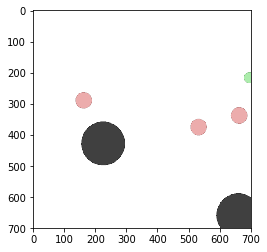

In [8]:
scenario_name = 'simple_tag'
# scenario_name = 'simple_world_comm'

# load scenario from script
scenario = scenario.load(scenario_name + ".py").Scenario()
# create world
world = scenario.make_world()
# create multiagent environment
env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation, info_callback=None, shared_viewer=True)

env = GymWrapper(env)

Args = namedtuple('Args', ['agent_num',
                           'hid_size',
                           'obs_size',
                           'continuous',
                           'action_dim',
                           'comm_iters',
                           'init_std',
                           'lrate',
                           'batch_size',
                           'max_steps',
                           'gamma',
                           'mean_ratio',
                           'normalize_rewards',
                           'advantages_per_action',
                           'value_coeff',
                           'entr',
                           'action_num'
                          ]
                 )

args = Args(agent_num=env.get_num_of_agents(),
            hid_size=100,
            obs_size=np.max(env.get_shape_of_obs()),
            continuous=False,
            action_dim=np.max(env.get_output_shape_of_act()),
            comm_iters=100,
            init_std=0.2,
            lrate=0.001,
            batch_size=32,
            max_steps=200,
            gamma=0.99,
            mean_ratio=0,
            normalize_rewards=True,
            advantages_per_action=False,
            value_coeff=0.001,
            entr=0.001,
            action_num=np.max(env.get_input_shape_of_act())
           )

policy_net = CommNet(args)
epoch = 0
for i in range(1000):
    train = Trainer(args, policy_net, env())
    train.train_batch()
    print ('This is the epoch: {} and the current advantage is: {}'.format(epoch, train.stats['action_loss']))
    epoch += 1
env.close()

In [ ]:
print ('This is the scenario observation: \n', dir(env))

In [ ]:
print (dir(env().observation_space[0]))
print (dir(env().action_space[0]))

In [ ]:
print (env()._get_obs(env().agents[1]))
print (env()._get_reward(env().agents[1]))
print (env().action_space)
print (env().observation_space)
print (env().agents)